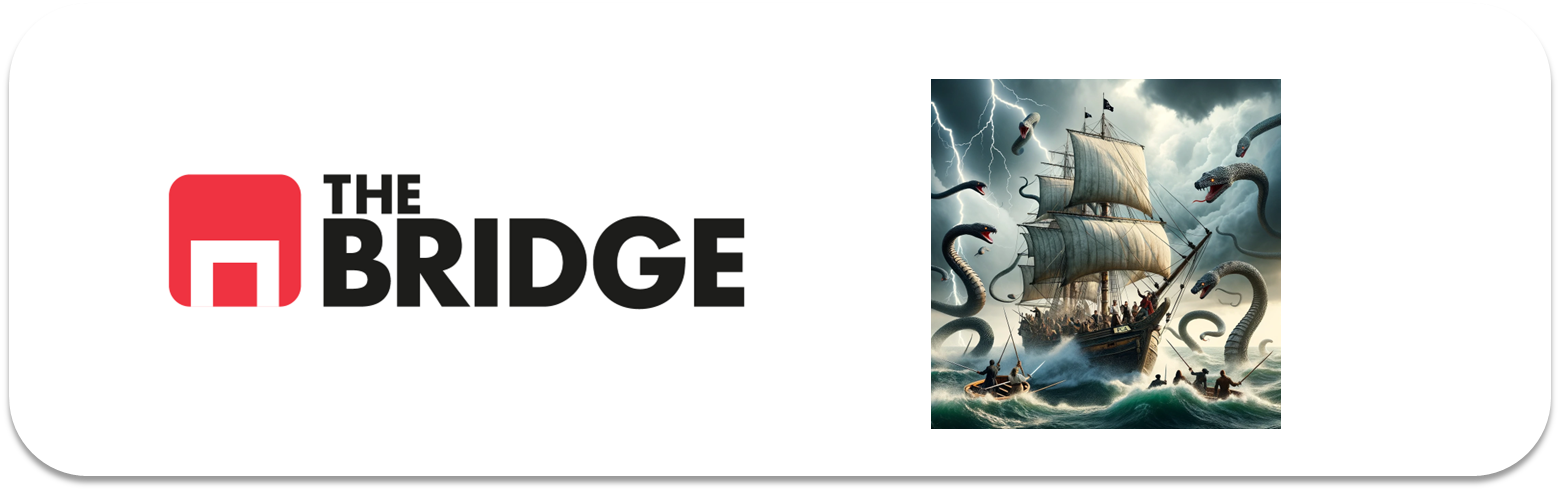

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
# 1. IMPORTACIÓN DE LIBRERÍAS

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [2]:
# 2. CARGA DEL DATASET

# Cargamos el dataset de caras de Olivetti desde sklearn
# Contiene 400 imágenes de 64x64 píxeles (4096 features por imagen)
olivetti = fetch_olivetti_faces()

# X: matriz de características (cada fila es una imagen aplanada)
# y: vector de etiquetas (identificador de la persona, de 0 a 39)
X = olivetti.data
y = olivetti.target

print("Shape de X (n_muestras, n_features):", X.shape)  # (400, 4096)
print("Shape de y (n_muestras,):", y.shape)             # (400,)


Shape de X (n_muestras, n_features): (400, 4096)
Shape de y (n_muestras,): (400,)


In [3]:
# 3. CREACIÓN DE DATAFRAME

# No es obligatorio, pero tener un DataFrame ayuda a inspeccionar los datos
df = pd.DataFrame(X)
df['target'] = y

df.head()


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4097 entries, 0 to target
dtypes: float32(4096), int64(1)
memory usage: 6.3 MB


In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.400134,0.434236,0.476281,0.518481,0.554845,0.588729,0.621426,0.647510,0.664814,0.676591,...,0.367221,0.363027,0.355506,0.340196,0.338657,0.335909,0.321415,0.313647,0.310455,19.500000
std,0.180695,0.189504,0.194742,0.193313,0.188593,0.178481,0.167109,0.155024,0.147616,0.143583,...,0.181861,0.181611,0.188709,0.186088,0.189256,0.195280,0.187842,0.183616,0.180635,11.557853
min,0.086777,0.066116,0.090909,0.041322,0.107438,0.107438,0.115702,0.115702,0.119835,0.140496,...,0.037190,0.053719,0.049587,0.033058,0.012397,0.049587,0.057851,0.061983,0.033058,0.000000
25%,0.243802,0.267562,0.314050,0.383264,0.446281,0.515496,0.544421,0.581612,0.599174,0.611570,...,0.214876,0.219008,0.197314,0.177686,0.177686,0.173554,0.173554,0.173554,0.172521,9.750000
50%,0.392562,0.458678,0.512397,0.545455,0.584711,0.615702,0.652893,0.669421,0.683884,0.702479,...,0.367769,0.342975,0.334711,0.320248,0.314050,0.299587,0.289256,0.270661,0.272727,19.500000
75%,0.528926,0.575413,0.636364,0.666322,0.702479,0.714876,0.735537,0.757231,0.772727,0.780992,...,0.496901,0.500000,0.500000,0.479339,0.462810,0.462810,0.446281,0.414256,0.417355,29.250000
max,0.805785,0.822314,0.871901,0.892562,0.871901,0.871901,0.871901,0.871901,0.871901,0.871901,...,0.904959,0.888430,0.896694,0.826446,0.863636,0.921488,0.929752,0.884298,0.822314,39.000000


In [6]:
# 4. SPLIT TRAIN / TEST

# Queremos:
# - Al menos 80 instancias en test
# - Split estratificado por la etiqueta (para mantener proporciones de clases)
# - Reproducibilidad con random_state

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=80,          # 80 imágenes en test que lo dice el enunciado
    stratify=y,            # estratificado por la clase
    random_state=42
)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)


Shape X_train: (320, 4096)
Shape X_test: (80, 4096)
Shape y_train: (320,)
Shape y_test: (80,)


In [7]:
# 5. MINI EDA (RÁPIDA)
# 5.1. Número de clases y valores únicos
print("Clases únicas:", np.unique(y))
print("Número de clases:", len(np.unique(y)))

# 5.2. Imágenes por clase en train
# np.bincount cuenta cuántas veces aparece cada etiqueta
counts_train = np.bincount(y_train)
print("Imágenes por clase en train:", counts_train)

# Comentario:
# - Sabemos que el dataset está limpio (viene de sklearn).
# - Todas las features son numéricas (píxeles).
# - No hay NaNs.
# - Para este ejercicio, un EDA más profundo no es crítico.


Clases únicas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Número de clases: 40
Imágenes por clase en train: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8]


In [8]:
# 6. DEFINICIÓN DEL MODELO BASELINE

# Usamos un Pipeline:
#  - StandardScaler: escala los píxeles (media 0, varianza 1)
#  - LogisticRegression: modelo de clasificación multiclase

baseline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, multi_class="multinomial"))
])


In [9]:
# 7. EVALUACIÓN BASELINE CON CROSS-VALIDATION

# Usamos 5-fold cross-validation sobre el conjunto de entrenamiento
# Métrica: balanced_accuracy (recall medio entre clases)

baseline_cv_scores = cross_val_score(
    baseline_clf,
    X_train,
    y_train,
    cv=5,
    scoring="balanced_accuracy"
)

baseline_cv_mean = baseline_cv_scores.mean()
print("Baseline balanced_accuracy (CV 5-fold):", baseline_cv_mean)


Baseline balanced_accuracy (CV 5-fold): 0.9525


In [10]:

# 8A.1. CLASSIFICATION REPORT EN TRAIN

from sklearn.metrics import classification_report

# Entrenamos el modelo con TODO el train
baseline_clf.fit(X_train, y_train)

# Predicción sobre el propio train
y_pred_train = baseline_clf.predict(X_train)

print("Classification Report (TRAIN)")
print(classification_report(y_train, y_pred_train))


Classification Report (TRAIN)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00        

In [11]:
# 8B. MÉTRICA EN TEST
# Predecimos sobre el conjunto de test
y_pred_test = baseline_clf.predict(X_test)

# Calculamos la balanced_accuracy en test
baseline_test_score = balanced_accuracy_score(y_test, y_pred_test)

print("Balanced Accuracy BASELINE (TEST):", baseline_test_score)
# IMPORTANTE: guardamos baseline_cv_mean y baseline_test_score
# para compararlos luego con los modelos con PCA.

Balanced Accuracy BASELINE (TEST): 0.9625


In [12]:
# 8B.1. CLASSIFICATION REPORT EN TEST

print("=== Classification Report (TEST) ===")
print(classification_report(y_test, y_pred_test))


=== Classification Report (TEST) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       0.67      1.00      0.80         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00 

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [13]:
from sklearn.decomposition import PCA


In [14]:
# 1. INSTANCIAR PCA SIN N_COMPONENTS

pca_full = PCA()  # lo dice ele jericio sin pasar argumentos
pca_full.fit(X_train)

n_features = X_train.shape[1]  # 4096 píxeles
print("Número de features originales:", n_features)


Número de features originales: 4096


In [16]:
# 2. DEFINIR RANGO DE COMPONENTES SEGÚN COMPRESIÓN


min_ratio = 0.002   # 0.2%
max_ratio = 0.025   # 2.5%

min_components = int(np.ceil(min_ratio * n_features))   # ~8
max_components = int(np.floor(max_ratio * n_features))  # ~102

print("Mínimo nº de componentes:", min_components)
print("Máximo nº de componentes:", max_components)


Mínimo nº de componentes: 9
Máximo nº de componentes: 102


In [17]:
# 3. LISTA DE COMPONENTES A PROBAR

components_list = [8, 16, 32, 64, 96]
print("Componentes a probar:", components_list)


Componentes a probar: [8, 16, 32, 64, 96]


In [18]:
# 4. ENTRENAR MODELOS CON PCA

results = []

for n_comp in components_list:
    
    compression_ratio = n_comp / n_features
    
    pca_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_comp)),
        ("lr", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ])
    
    # Métrica en TRAIN (CV)
    cv_scores = cross_val_score(
        pca_clf,
        X_train,
        y_train,
        cv=5,
        scoring="balanced_accuracy"
    )
    cv_mean = cv_scores.mean()
    
    # Métrica en TEST
    pca_clf.fit(X_train, y_train)
    y_pred_test = pca_clf.predict(X_test)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    results.append({
        "n_components": n_comp,
        "compression_%": compression_ratio * 100,
        "cv_score": cv_mean,
        "test_score": test_score,
        "delta_cv_vs_baseline": cv_mean - baseline_cv_mean,
        "delta_test_vs_baseline": test_score - baseline_test_score
    })

results_df = pd.DataFrame(results)
results_df


,n_components,compression_%,cv_score,test_score,delta_cv_vs_baseline,delta_test_vs_baseline
0,8,0.195312,0.8075,0.7625,-0.1450,-0.2000
1,16,0.390625,0.9175,0.9375,-0.0350,-0.0250
2,32,0.781250,0.9550,0.9625,0.0025,0.0000
3,64,1.562500,0.9625,0.9750,0.0100,0.0125
4,96,2.343750,0.9675,0.9750,0.0150,0.0125


In [19]:
# 5. SELECCIÓN DEL MEJOR Nº DE COMPONENTES

results_df_sorted = results_df.sort_values("compression_%")

mask_3 = (results_df_sorted["delta_cv_vs_baseline"] >= -0.03) & \
         (results_df_sorted["delta_test_vs_baseline"] >= -0.03)

candidates_3 = results_df_sorted[mask_3]

if not candidates_3.empty:
    best_row = candidates_3.iloc[0]
    criterio = "pérdida < 3 puntos"
else:
    mask_5 = (results_df_sorted["delta_cv_vs_baseline"] >= -0.05) & \
             (results_df_sorted["delta_test_vs_baseline"] >= -0.05)
    candidates_5 = results_df_sorted[mask_5]
    
    if not candidates_5.empty:
        best_row = candidates_5.iloc[0]
        criterio = "pérdida < 5 puntos"
    else:
        best_row = None
        criterio = "ningún modelo cumple los criterios"

best_row, criterio


(n_components              32.00000
 compression_%              0.78125
 cv_score                   0.95500
 test_score                 0.96250
 delta_cv_vs_baseline       0.00250
 delta_test_vs_baseline     0.00000
 Name: 2, dtype: float64,
 'pérdida < 3 puntos')

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [21]:
from sklearn.decomposition import PCA


In [22]:
# 3.1. RANGO DE COMPONENTES PARA COMPRESIÓN FUERTE
#      Entre el 0.1% y el 1% del tamaño original


n_features = X_train.shape[1]  # 4096

min_ratio_3 = 0.001   # 0.1%
max_ratio_3 = 0.01    # 1%

min_components_3 = int(np.ceil(min_ratio_3 * n_features))   # ~5
max_components_3 = int(np.floor(max_ratio_3 * n_features))  # ~40

print("Mínimo nº de componentes (parte 3):", min_components_3)
print("Máximo nº de componentes (parte 3):", max_components_3)


Mínimo nº de componentes (parte 3): 5
Máximo nº de componentes (parte 3): 40


In [23]:
# 3.2. LISTA DE NÚMEROS DE COMPONENTES A PROBAR
#      (al menos 5 valores dentro del rango)

components_list_3 = [4, 8, 16, 24, 32]  # ajusta si quieres
print("Componentes a probar (parte 3):", components_list_3)


Componentes a probar (parte 3): [4, 8, 16, 24, 32]


In [24]:
# 3.3. ENTRENAR MODELOS CON IMÁGENES DESCOMPRIMIDAS

results_3 = []

for n_comp in components_list_3:
    print(f"\n=== Probando {n_comp} componentes ===")
    
    compression_ratio = n_comp / n_features  # proporción de tamaño
    
    # 1) Ajustamos PCA sobre X_train
    pca_zip = PCA(n_components=n_comp)
    pca_zip.fit(X_train)
    
    # 2) Comprimimos y descomprimimos X_train
    X_train_compressed = pca_zip.transform(X_train)
    X_train_unzipped = pca_zip.inverse_transform(X_train_compressed)
    
    # 3) Comprimimos y descomprimimos X_test
    X_test_compressed = pca_zip.transform(X_test)
    X_test_unzipped = pca_zip.inverse_transform(X_test_compressed)
    
    # 4) Entrenamos el mismo modelo baseline pero sobre datos "reconstruidos"
    clf_unzipped = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ])
    
    clf_unzipped.fit(X_train_unzipped, y_train)
    
    # 5) Evaluamos en test
    y_pred_test_unzipped = clf_unzipped.predict(X_test_unzipped)
    test_score_unzipped = balanced_accuracy_score(y_test, y_pred_test_unzipped)
    
    print("Balanced Accuracy (TEST) con descompresión:", test_score_unzipped)
    
    results_3.append({
        "n_components": n_comp,
        "compression_%": compression_ratio * 100,
        "test_score_unzipped": test_score_unzipped,
        "delta_test_vs_baseline": test_score_unzipped - baseline_test_score
    })

results_3_df = pd.DataFrame(results_3)
results_3_df



=== Probando 4 componentes ===


c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Balanced Accuracy (TEST) con descompresión: 0.4125

=== Probando 8 componentes ===
Balanced Accuracy (TEST) con descompresión: 0.7375

=== Probando 16 componentes ===
Balanced Accuracy (TEST) con descompresión: 0.925

=== Probando 24 componentes ===
Balanced Accuracy (TEST) con descompresión: 0.9375

=== Probando 32 componentes ===
Balanced Accuracy (TEST) con descompresión: 0.9625


,n_components,compression_%,test_score_unzipped,delta_test_vs_baseline
0,4,0.097656,0.4125,-0.5500
1,8,0.195312,0.7375,-0.2250
2,16,0.390625,0.9250,-0.0375
3,24,0.585938,0.9375,-0.0250
4,32,0.781250,0.9625,0.0000


In [25]:
# 3.4. VISUALIZACIÓN SIMPLE (TABLA)

results_3_df.sort_values("compression_%")


,n_components,compression_%,test_score_unzipped,delta_test_vs_baseline
0,4,0.097656,0.4125,-0.5500
1,8,0.195312,0.7375,-0.2250
2,16,0.390625,0.9250,-0.0375
3,24,0.585938,0.9375,-0.0250
4,32,0.781250,0.9625,0.0000


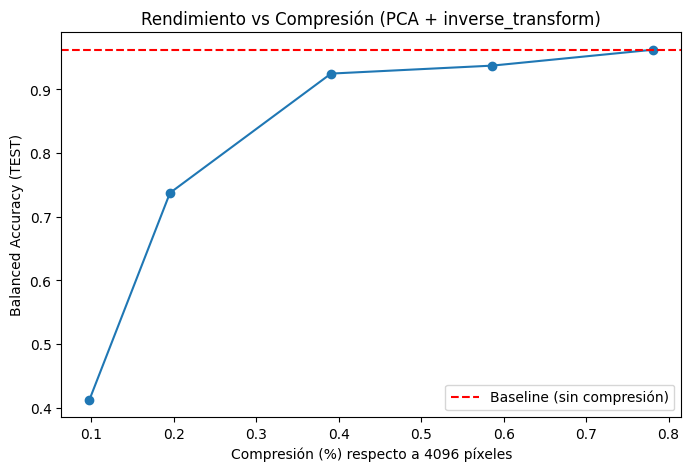

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_3_df["compression_%"], results_3_df["test_score_unzipped"], marker="o")
plt.axhline(baseline_test_score, color="red", linestyle="--", label="Baseline (sin compresión)")
plt.xlabel("Compresión (%) respecto a 4096 píxeles")
plt.ylabel("Balanced Accuracy (TEST)")
plt.title("Rendimiento vs Compresión (PCA + inverse_transform)")
plt.legend()
plt.show()


In [27]:
# 3.5. SELECCIÓN DEL Nº DE COMPONENTES (PÉRDIDA < 3 PUNTOS)

# Pérdida < 3 puntos => delta >= -0.03
mask_3_post = results_3_df["delta_test_vs_baseline"] >= -0.03

candidates_3_post = results_3_df[mask_3_post].sort_values("compression_%")

if not candidates_3_post.empty:
    best_row_3 = candidates_3_post.iloc[0]  # mayor compresión (menor %)
    print("Mejor configuración (pérdida < 3 puntos):")
    print(best_row_3)
else:
    print("No hay configuración con pérdida < 3 puntos porcentuales.")


Mejor configuración (pérdida < 3 puntos):
n_components              24.000000
compression_%              0.585938
test_score_unzipped        0.937500
delta_test_vs_baseline    -0.025000
Name: 3, dtype: float64


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 320 PCs para que se vea que son las mismas claras con claridad.

In [ ]:
# EXTRA 2. FUNCIÓN PARA VER CARA ORIGINAL VS DESCOMPRIMIDA

def show_original_vs_reconstructed(X_data, pca_model, n_samples=5, title_suffix=""):
    """
    Muestra n_samples caras originales y sus versiones reconstruidas
    a partir de una PCA ya entrenada.
    """
    import matplotlib.pyplot as plt
    
    # Seleccionamos índices aleatorios
    idxs = np.random.choice(X_data.shape[0], size=n_samples, replace=False)
    
    # Comprimimos y descomprimimos
    X_compressed = pca_model.transform(X_data[idxs])
    X_reconstructed = pca_model.inverse_transform(X_compressed)
    
    plt.figure(figsize=(10, 4 * n_samples))
    
    for i, idx in enumerate(idxs):
        # Original
        plt.subplot(n_samples, 2, 2*i + 1)
        plt.imshow(X_data[idx].reshape(64, 64), cmap="gray")
        plt.title(f"Original {title_suffix}")
        plt.axis("off")
        
        # Reconstruida
        plt.subplot(n_samples, 2, 2*i + 2)
        plt.imshow(X_reconstructed[i].reshape(64, 64), cmap="gray")
        plt.title(f"Reconstruida {title_suffix}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()



=== Reconstrucción con 4 componentes ===


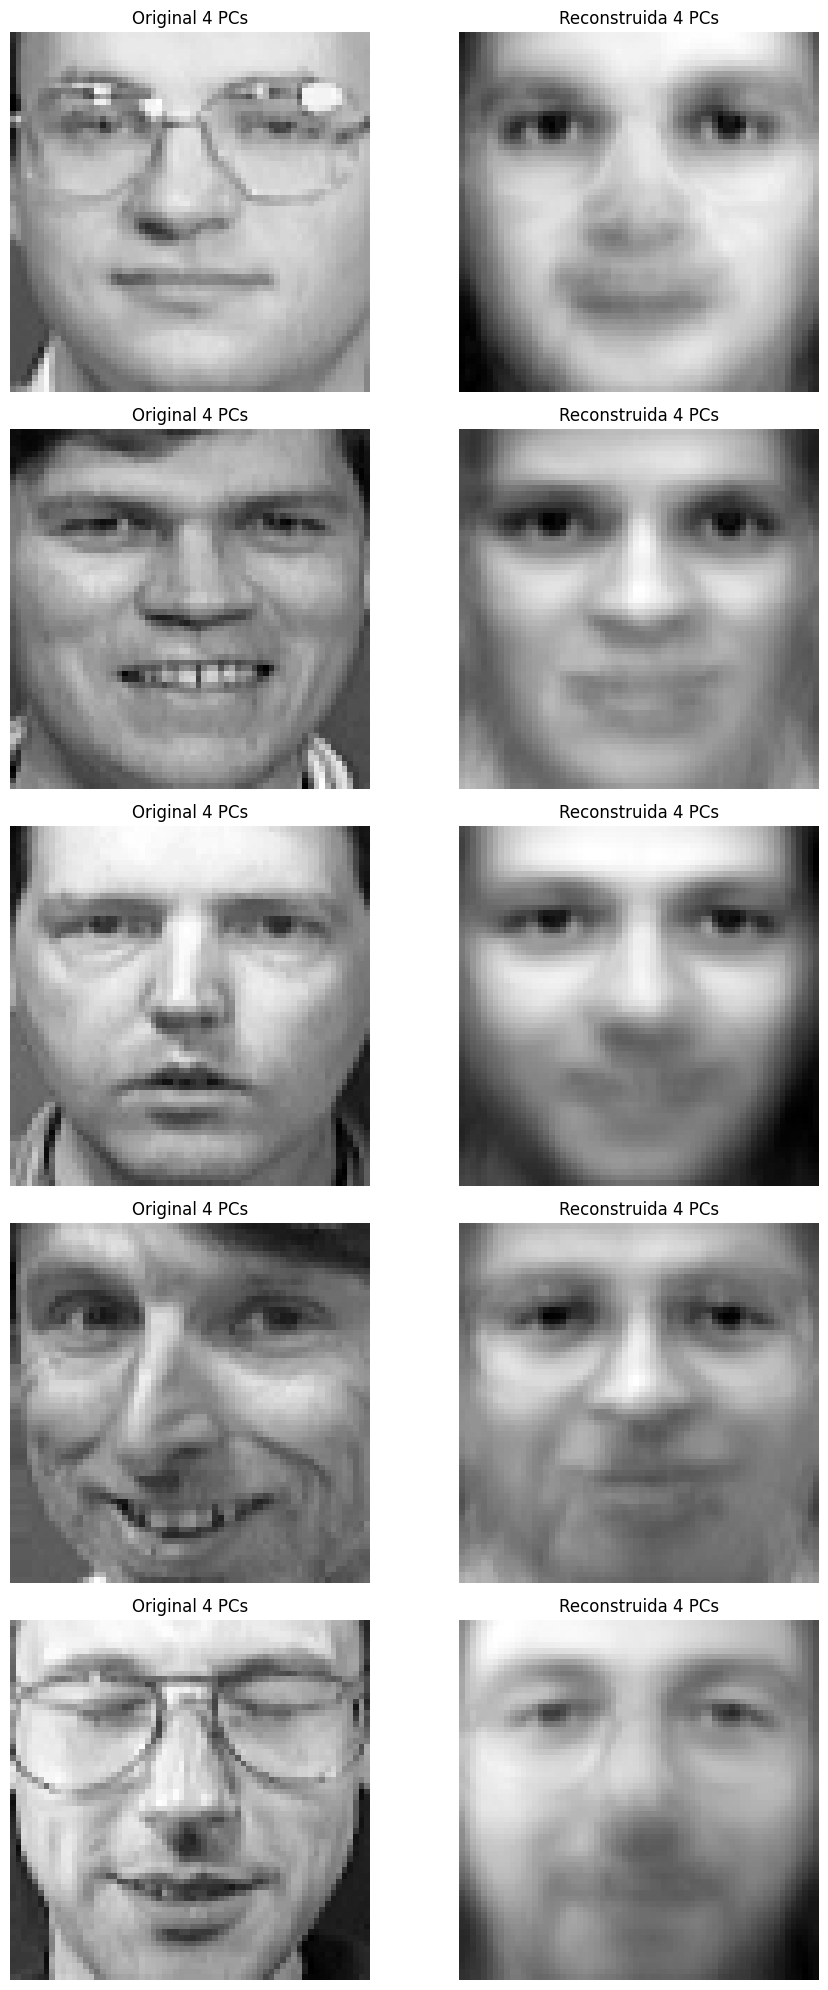


=== Reconstrucción con 8 componentes ===


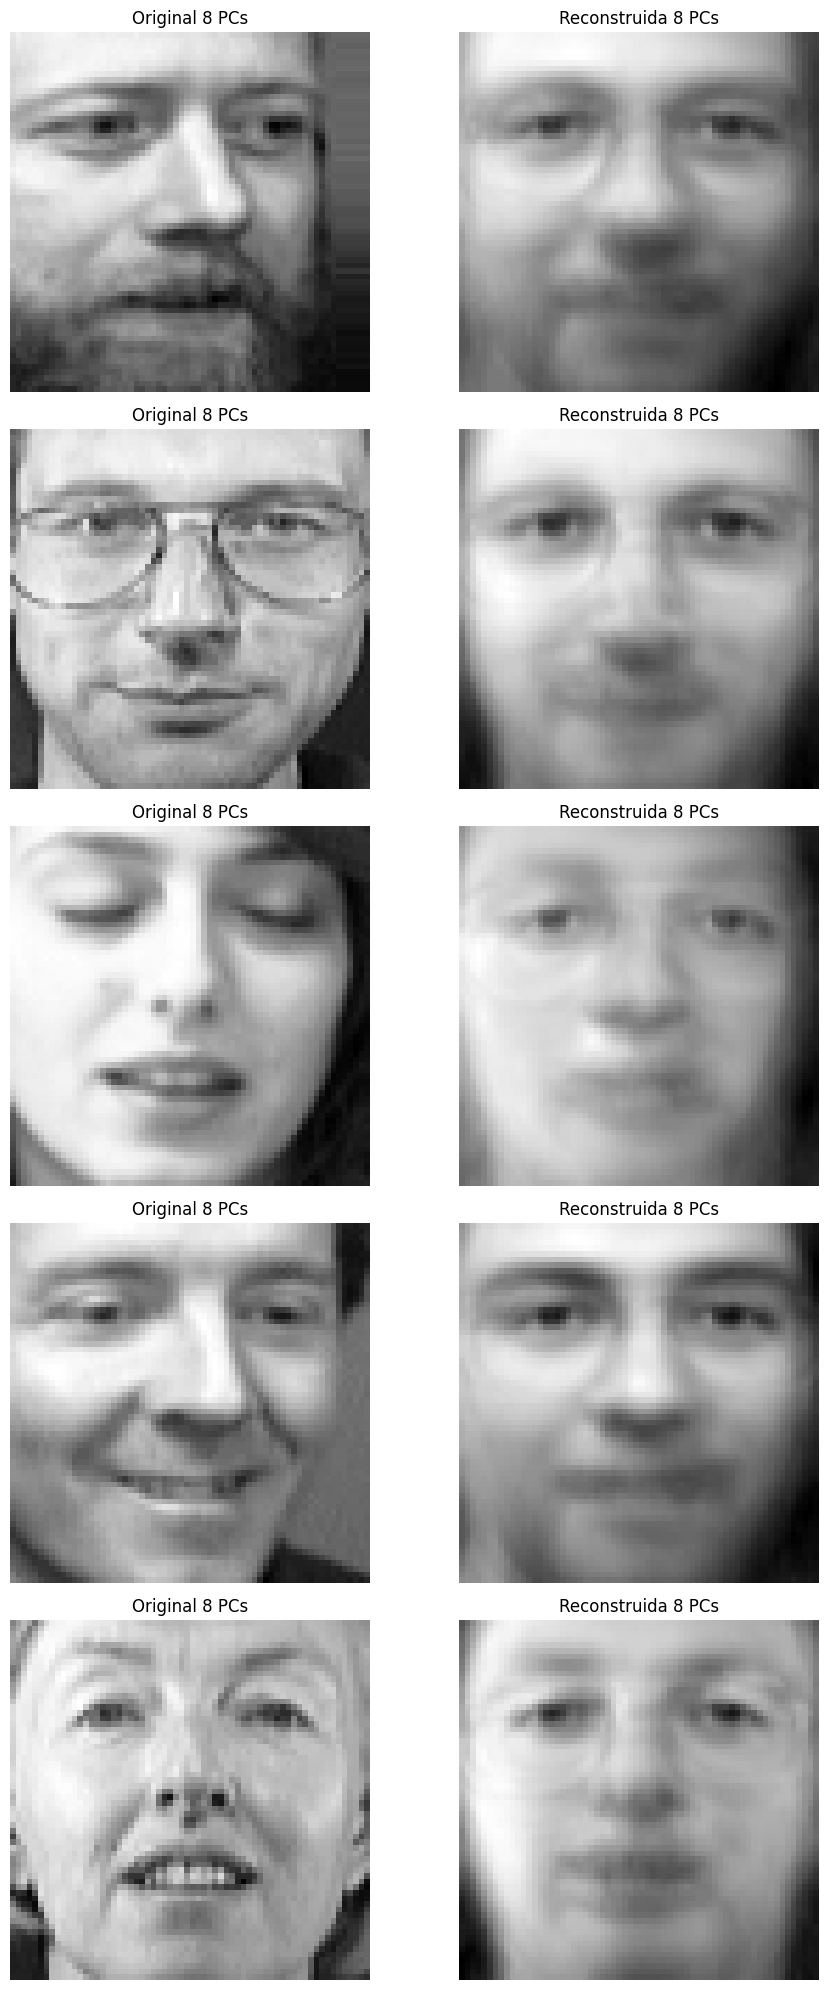


=== Reconstrucción con 16 componentes ===


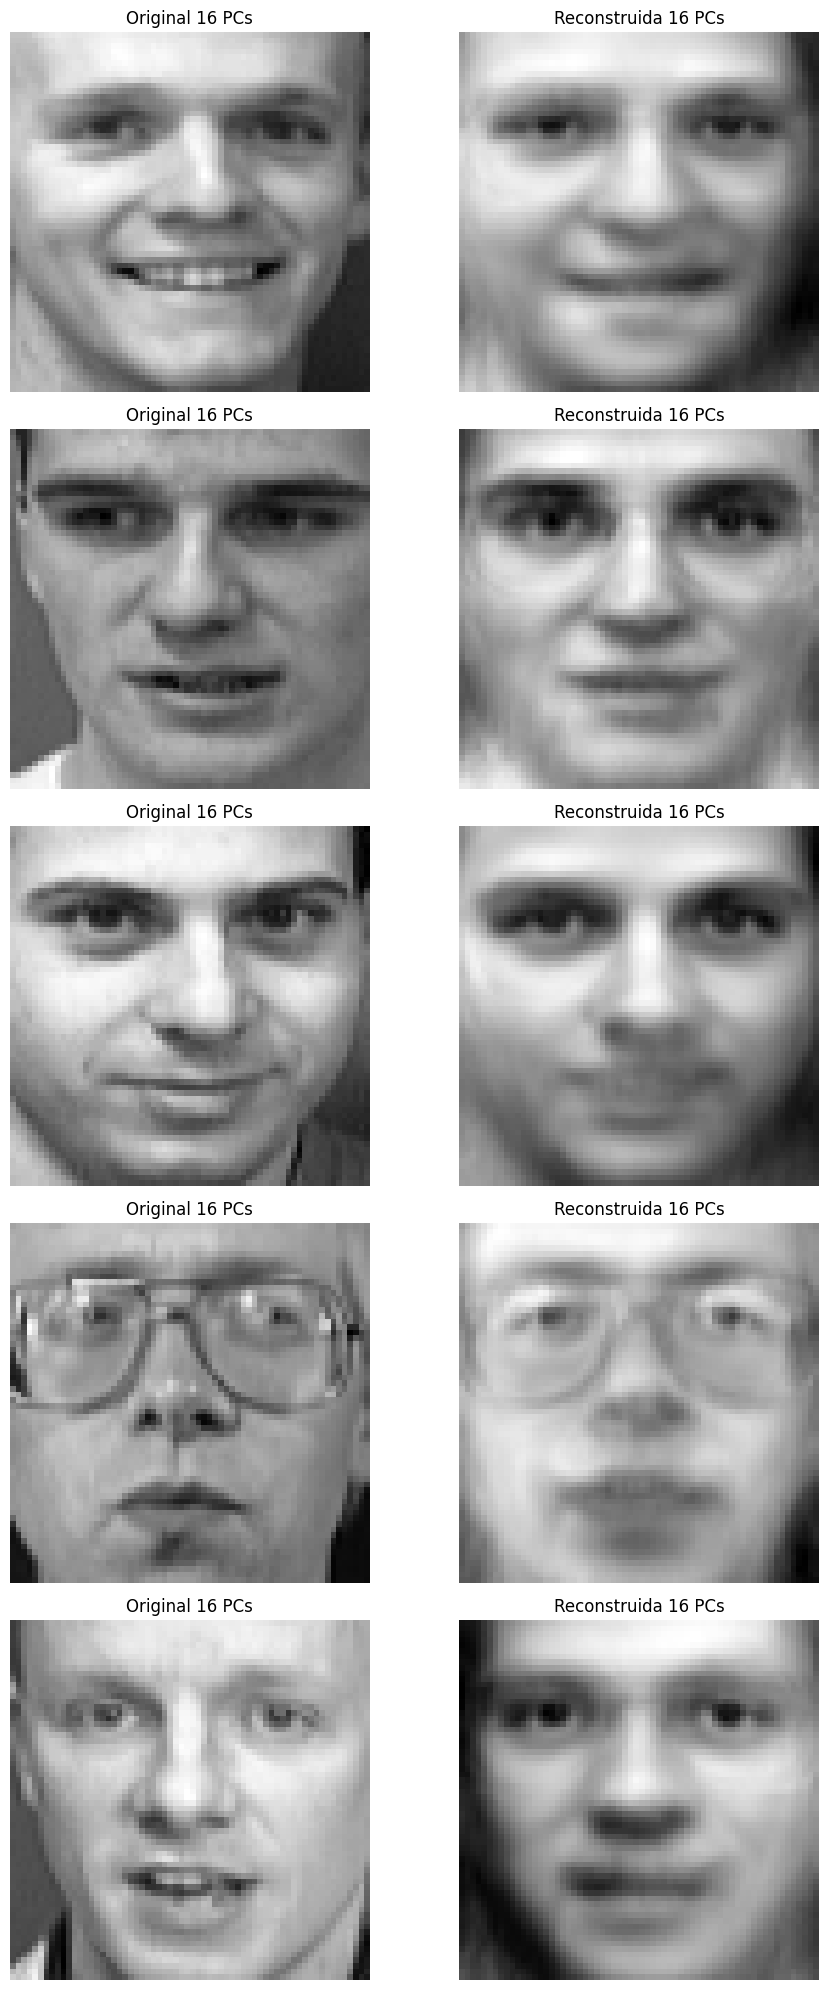


=== Reconstrucción con 24 componentes ===


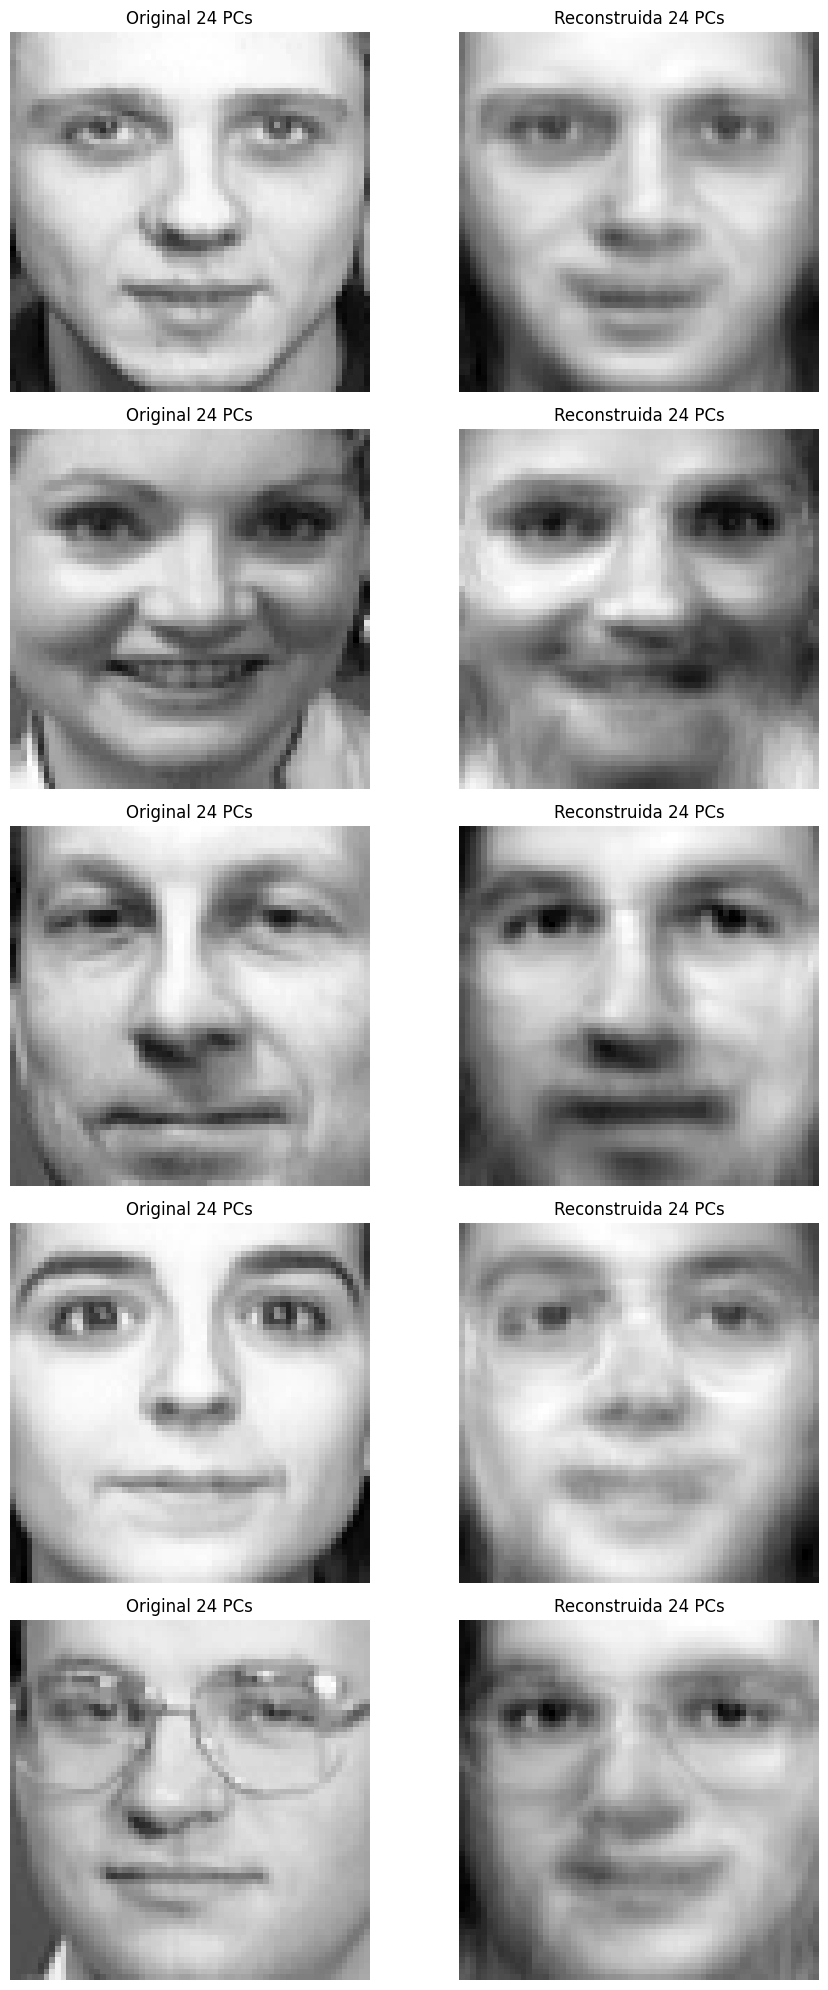


=== Reconstrucción con 32 componentes ===


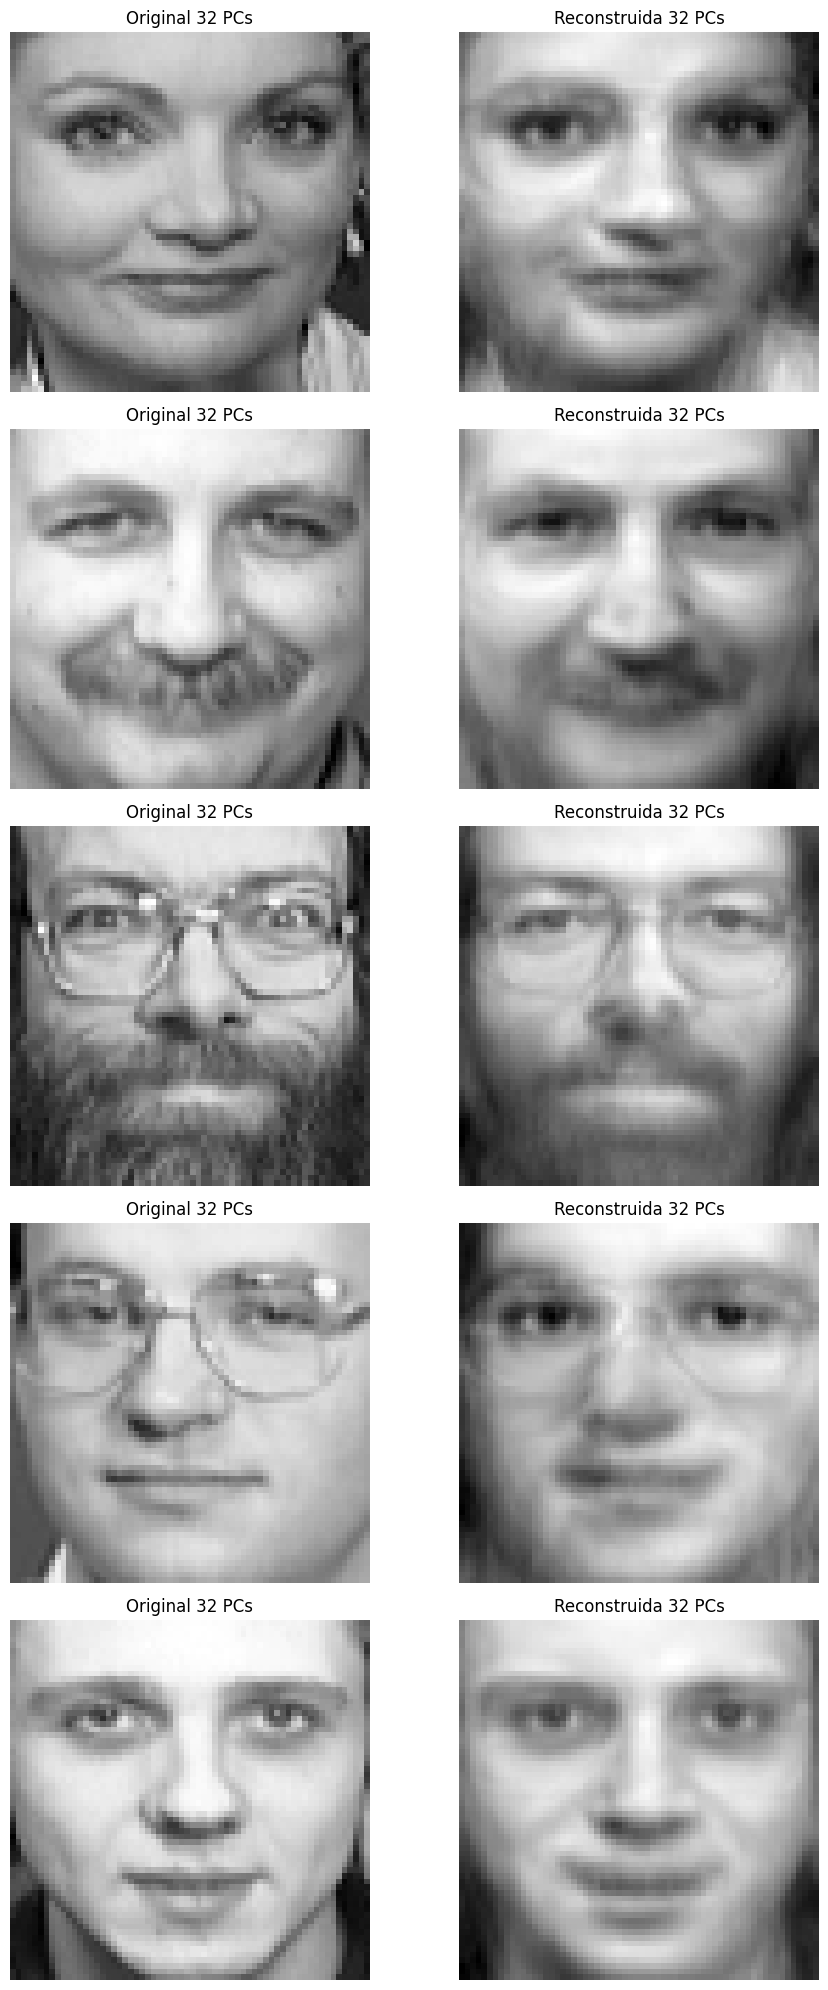


=== Reconstrucción con 150 componentes ===


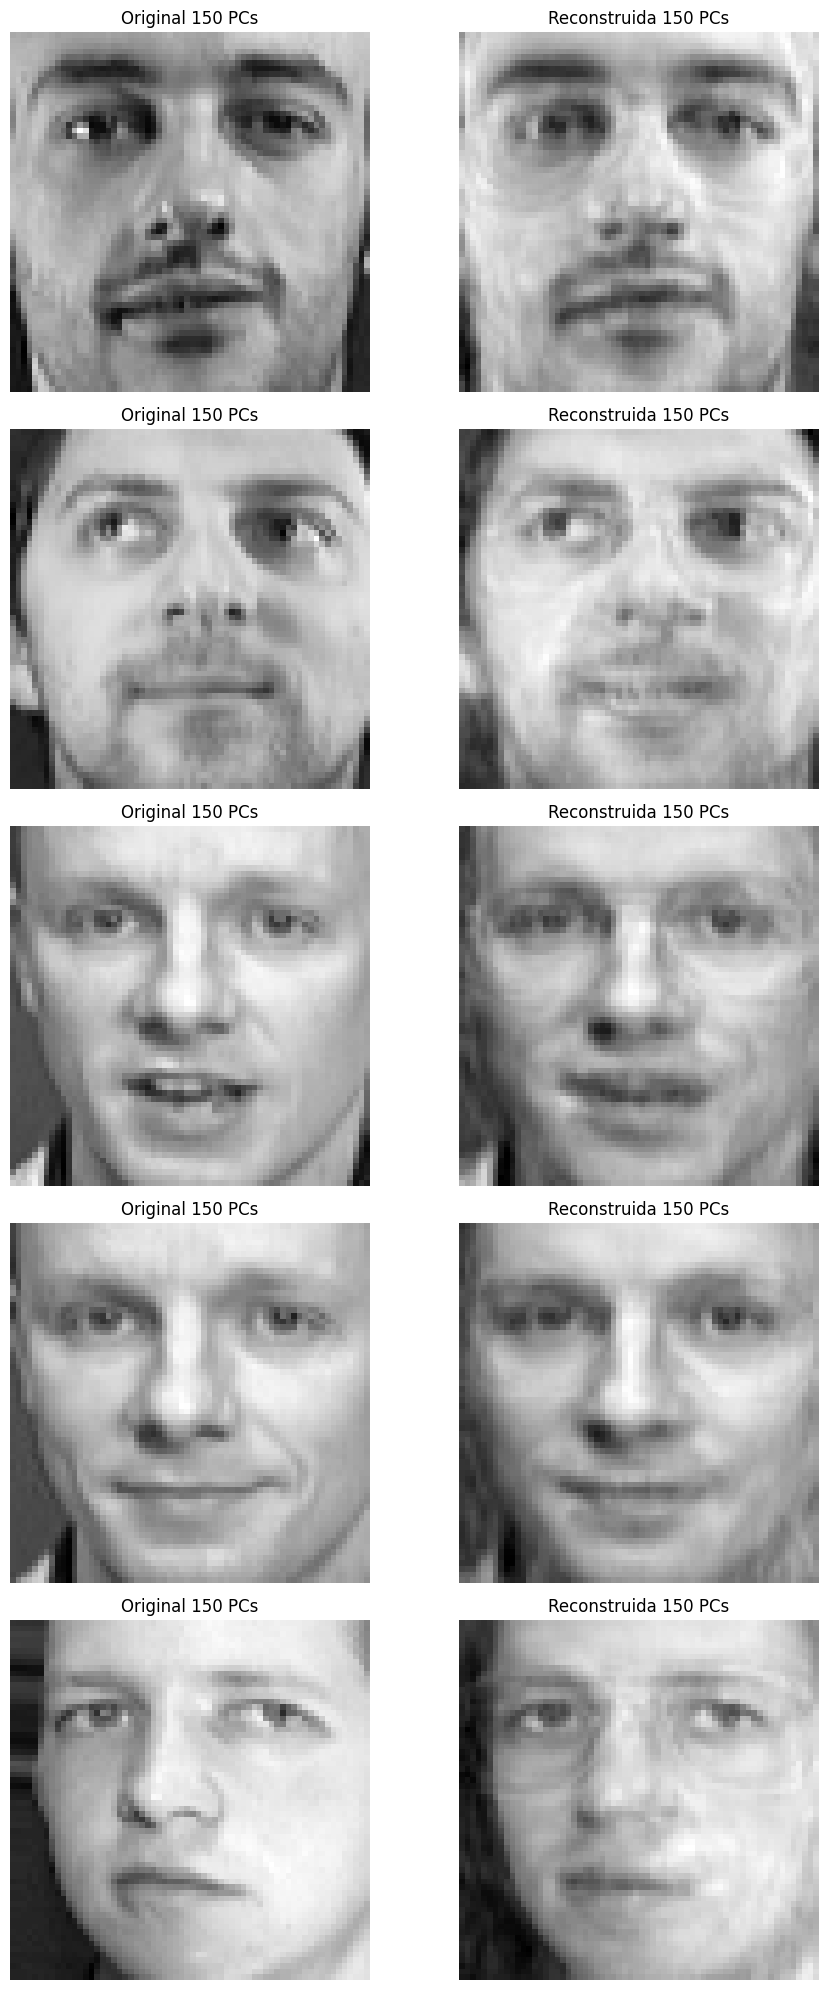


=== Reconstrucción con 320 componentes ===


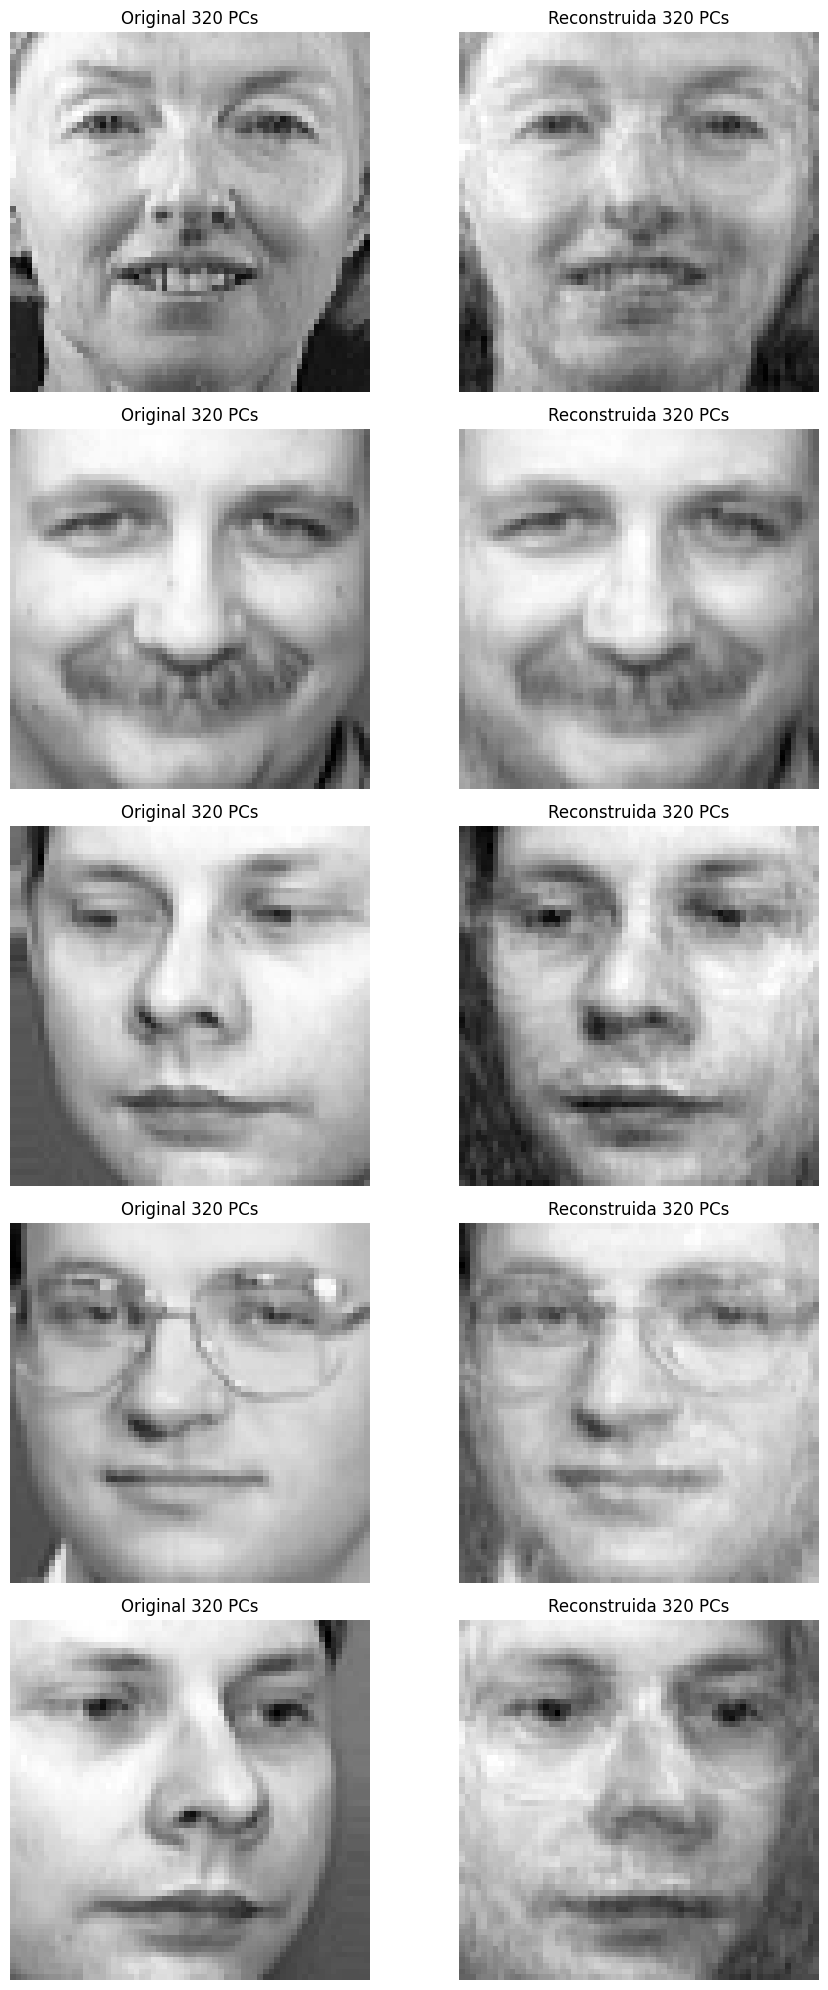

In [29]:
# EXTRA 2. PROBAR DISTINTOS NÚMEROS DE PCS

# 1) Valores de la parte 3
for n_comp in components_list_3:
    print(f"\n=== Reconstrucción con {n_comp} componentes ===")
    pca_tmp = PCA(n_components=n_comp)
    pca_tmp.fit(X_train)
    show_original_vs_reconstructed(X_test, pca_tmp, n_samples=5, title_suffix=f"{n_comp} PCs")

# 2) Caso 150 PCs
print("\n=== Reconstrucción con 150 componentes ===")
pca_150 = PCA(n_components=150)
pca_150.fit(X_train)
show_original_vs_reconstructed(X_test, pca_150, n_samples=5, title_suffix="150 PCs")

# 3) Caso 320 PCs
print("\n=== Reconstrucción con 320 componentes ===")
pca_320 = PCA(n_components=320)
pca_320.fit(X_train)
show_original_vs_reconstructed(X_test, pca_320, n_samples=5, title_suffix="320 PCs")
